# Building a text processing application
___


### Challenge

`Building a text processing application that can`: 


1. `reverse` a string:
    "hello"-> "olleh"

2. `convert` a string to uppercase:
    "hello" -> "HELLO"

The application should:

1. Accept user input and action type

2. Route to the appropriate node (reverse or upper) based on the action

3. Handle invalid actions gracefully


This will be achieved by routing the input through LangGraph nodes using a conditional edge

The arquitecture solution should start by thinking the `AgentState`.

* State should have user string and the action type
* should have two NODES: 
    1. reverse_node(State) -> given a input string, reverse the input string. 
    2. upper_node(State) -> given a input string, upper the string.
* Handle invalid actions gracefully
* should add logging for each node action - using loguru (simple implementation)

### Summary of Architecture Documentation:

Your text processing application now has **professional, comprehensive documentation** for all nodes:

1. **`State` class**: Complete TypedDict documentation with examples
2. **`reverse_node`**: String reversal with logging and error handling  
3. **`upper_node`**: Uppercase conversion with comprehensive docs
4. **`router_node`**: Central routing logic with robust error handling
5. **`invalid_action_node`**: Graceful fallback for invalid actions

Each function follows **Google-style docstring standards** with:
- Clear purpose descriptions
- Detailed Args and Returns sections  
- Practical examples
- Important notes about behavior
- Proper type hints with `# type: ignore` comments

This creates a **well-documented, production-ready** LangGraph application that's easy to maintain and extend! 🚀

In [ ]:
from typing import TypedDict

from IPython.display import Image
from IPython.display import display as ipy_display
from langgraph.graph import END, START, StateGraph
from loguru import logger

The state must have all the information that needs to flow from one NODE to another in order to get the job done.

In [ ]:
# Configuração básica do logger (apenas console)
logger.remove()  # remove configuração padrão
logger.add(lambda msg: print(msg, end=""))  # imprime no notebook sem duplicar

1

In [ ]:
class State(TypedDict):
    """State management for the text processing application.

    This class defines the state structure for LangGraph nodes in the text processing
    workflow. The state contains all necessary information that flows between nodes to
    complete text transformation operations.

    Attributes:
        user_string (str): The input text string to be processed. This is
        the raw text that will undergo transformation based on the specified action type.

        action_type (str): The type of text processing operation to perform.
            Valid values are:
                - "reverse": Reverses the character order of the input string
                - "upper": Converts all characters in the string to uppercase

    Example:
        >>> state = State(
        ...     user_string="hello world",
        ...     action_type="reverse"
        ... )
        >>> # This state will be processed by the reverse_node

    Note:
        This TypedDict is used by LangGraph to maintain type safety and ensure
        consistent data flow between processing nodes. Invalid action_type
        values will be handled gracefully by the router function.

    """

    user_string: str
    action_type: str

#### 1. Reverse Node

In [ ]:
def reverse_node(state: State) -> State:
    """Reverse the input string.

    This function takes the current state, extracts the user_string, reverses it,
    and updates the state with the reversed string.

    Args:
        state: The current state of the application, containing the user_string
            to be reversed.

    Returns:
        The updated state with the reversed user_string.

    Example:
        >>> input_state = {"user_string": "hello world", "action_type": "reverse"}
        >>> result = reverse_node(input_state)
        >>> print(result["user_string"])
        'dlrow olleh'

    Note:
        This function uses Python's string slicing to reverse the input string.

    """
    user_string = state["user_string"]
    logger.info(f"Input string: {user_string}")

    reversed_string = user_string[::-1]
    logger.debug(f"Reversed string: {reversed_string}")

    new_state = {"user_string": reversed_string}
    logger.success("State updated successfully")
    return new_state  # type: ignore

#### 2. Upper Node

In [ ]:
def upper_node(state: State) -> State:
    """Convert the input string to uppercase.

    This function takes the current state, extracts the user_string, converts it
    to uppercase, and updates the state with the uppercased string.

    Args:
        state: The current state of the application, containing the user_string
            to be converted to uppercase.

    Returns:
        The updated state with the uppercased user_string.

    Example:
        >>> input_state = {"user_string": "hello world", "action_type": "upper"}
        >>> result = upper_node(input_state)
        >>> print(result["user_string"])
        'HELLO WORLD'

    Note:
        This function uses Python's str.upper() method which converts all
        cased characters to uppercase. Non-alphabetic characters remain unchanged.
        The function logs the transformation process for debugging purposes.

    """
    user_string = state["user_string"]
    logger.info(f"Input string: {user_string}")

    upper_string = user_string.upper()
    logger.debug(f"Uppercased string: {upper_string}")

    new_state = {"user_string": upper_string}
    logger.success("State updated successfully")
    return new_state  # type: ignore

#### 3. Router Node
____

##### **What is a Router Node?**

In LangGraph, a router is a special type of node that controls the flow of execution within the graph. Think of it as a "traffic cop" or a conditional if/else statement. Its job is to decide which node (or nodes) should be executed next based on the current state of the graph.

This allows you to create complex, non-linear workflows with branches and cycles, which is essential for building sophisticated agents and multi-step chains.

The core mechanism is simple:

1. A router is a function that takes the current `state` object as input.
2. Inside the function, you write the logic to inspect the state.
3. Based on that logic, the function returns a string (or a list of strings).
4. This returned string's value determines which downstream node to execute next.

#### **How to Implement a Router**

Implementing a router involves two main steps.

1. **Write the Router Function**: This is a standard Python function that contains your conditional logic.
2. **Wire it into the Graph**: You use the .add_conditional_edges() method on your graph object to connect the router's output to other nodes.

In [ ]:
def router_node(state: State) -> str:
    """Route input based on action_type.

    Args:
        state (State): Current workflow state with:
            - user_string (str): Text to process
            - action_type (str): Either "reverse" or "upper"

    Returns:
        str: Next node name:
            - "reverse_node" → reverse the string
            - "upper_node" → convert to uppercase
            - "invalid_action_node" → for unknown or missing action_type

    Note:
        All errors are caught and logged. The function never raises exceptions.

    """
    try:
        action_type = state.get("action_type")

        if not action_type:
            warning_message = "No action_type provided in state. Routing to \
            'invalid_action'."
            logger.warning("warning_message: {}", warning_message)
            return "invalid_action"

        if action_type == "reverse":
            return "reverse_node"
        if action_type == "upper":
            return "upper_node"
        error_message = (
            f"Unknown action_type: {action_type}. Routing to 'invalid_action'."
        )
        logger.error(f"error_message: {error_message}")
        return "invalid_action"

    except Exception:
        error_message = "Exception occurred in router_node: {e}"
        logger.exception(f"error_message: {error_message}")
        return "invalid_action"

### Workflow 
___

We'll use `StateGraph` to wire everything together. That tells the LangGraph how the state should flow from one node to the next.

1. Instantiate the Graph: We'll create an instance of StateGraph and pass our State class to it.

2. Add Nodes: We'll add each of our functions (reverse_node, upper_node) as a node in the graph, giving each one a unique name.

3. Set the Entry Point: We need to tell the graph where to start. Our starting point will be the router_node.

4. Add Conditional Edges: This is the most crucial step. We'll connect our router_node to the other nodes. The router's return value ("reverse_node" or "upper_node") will determine which path the graph takes. We will also define a fallback node for invalid actions.

5. Add Final Edges: After the reverse_node or upper_node finishes its work, the process should end. We'll connect both of them to the special END node.

6. Compile the Graph: Finally, we compile our graph definition into a runnable application.

In [ ]:
# First, create the missing invalid_action_node function
def invalid_action_node(state: State) -> State:
    """Handle invalid or unknown action types gracefully.

    This function serves as a fallback mechanism when the router encounters
    an action_type that doesn't match any valid processing operations. It
    creates a user-friendly error message and logs the incident for debugging
    purposes, ensuring the application doesn't crash on invalid inputs.

    Args:
        state (State): The current state containing:
            - user_string (str): The original input string that was to be processed.
            - action_type (str): The invalid action type that caused the routing
              to this fallback node.

    Returns:
        State: A new state dictionary containing:
            - user_string (str): An error message indicating the invalid action
              and the original string that was attempted to be processed.
            - action_type (str): The original invalid action_type for reference.

    Example:
        >>> invalid_state = {"user_string": "test", "action_type": "unknown"}
        >>> result = invalid_action_node(invalid_state)
        >>> print(result["user_string"])
        "❌ Invalid action 'unknown' for string 'test'"

    Note:
        This function is crucial for application robustness. It prevents the
        workflow from failing when users provide unexpected action types and
        provides clear feedback about what went wrong. All error cases are
        logged with appropriate severity levels.

    """
    action_type = state.get("action_type", "unknown")
    user_string = state.get("user_string", "")

    error_msg = f"❌ Invalid action '{action_type}' for string '{user_string}'"
    logger.error(f"🚫 Invalid action encountered: {action_type}")
    logger.warning("💡 Valid actions are: 'reverse', 'upper'")

    return {"user_string": error_msg, "action_type": action_type}

In [ ]:
# 1. Instantiate the graph
workflow = StateGraph(State)

# 2. Add the processing nodes
workflow.add_node("reverse_node", reverse_node)
workflow.add_node("upper_node", upper_node)
workflow.add_node("invalid_action_node", invalid_action_node)

# 3. Add conditional edges using the lecture format
"""
Using a dictionary is the more flexible and explicit method. You should use it when the
strings returned by your path function do not exactly match the names of your 
destination nodes, or when you want your code to be more readable.
"""
workflow.add_conditional_edges(
    source=START,
    path=router_node,  # Your router function
    path_map={
        # "output_from_router": "name_of_node_to_go_to"
        "reverse_node": "reverse_node",
        "upper_node": "upper_node",
        "invalid_action": "invalid_action_node",  # <--- THIS IS THE FIX
    },
)

# 4. Add edges from processing nodes to the end
workflow.add_edge("reverse_node", END)
workflow.add_edge("upper_node", END)
workflow.add_edge("invalid_action_node", END)

# 5. Compile the graph
graph = workflow.compile()

print("✅ Workflow compiled successfully!")

✅ Workflow compiled successfully!


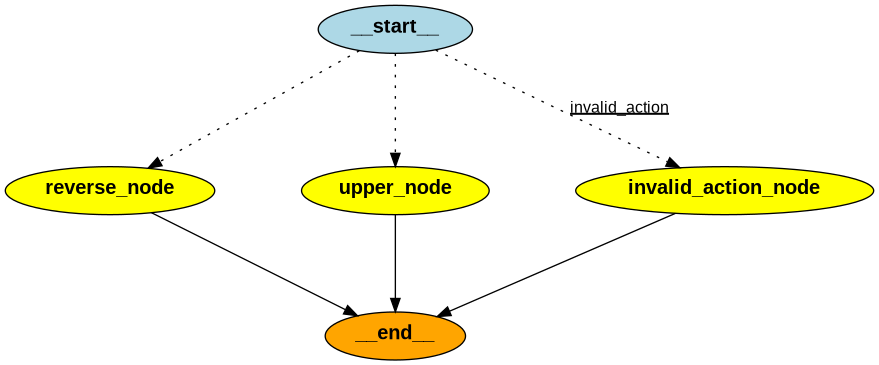

In [ ]:
# You may need to install the necessary libraries first
# pip install pygraphviz

try:
    # This line gets the graph structure and renders it as a PNG image
    png_image = graph.get_graph().draw_png()

    # This line displays the image in your notebook's output
    ipy_display(Image(png_image))

except Exception as e:
    print(f"Error drawing graph: {e}")
    print("Please ensure you have installed both 'graphviz' and 'pygraphviz'.")
    print("For Ubuntu/Debian: sudo apt-get install graphviz")
    print("For macOS (using Homebrew): brew install graphviz")

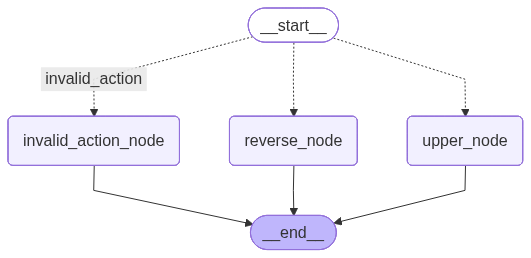

In [ ]:
ipy_display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 1. Define the user's input as a dictionary
# The keys MUST match the keys in your State class
user_input = {
    "user_string": "LangGraph is powerful",
    "action_type": "reverse",  # You can change this to "upper" or something invalid to test
}

# 2. Execute the workflow by calling .invoke() with the input
print(f"🚀 Starting workflow with input: {user_input}")
final_state = graph.invoke(user_input)

# 3. The output is the final state of the graph
print(f"✅ Workflow finished. Final state: {final_state}")

🚀 Starting workflow with input: {'user_string': 'LangGraph is powerful', 'action_type': 'reverse'}
2025-09-16 11:34:46.752 | INFO     | __main__:reverse_node:25 - Input string: LangGraph is powerful
2025-09-16 11:34:46.752 | DEBUG    | __main__:reverse_node:28 - Reversed string: lufrewop si hparGgnaL
2025-09-16 11:34:46.752 | SUCCESS  | __main__:reverse_node:31 - State updated successfully
✅ Workflow finished. Final state: {'user_string': 'lufrewop si hparGgnaL', 'action_type': 'reverse'}


In [ ]:
# 1. Define the user's input as a dictionary
# The keys MUST match the keys in your State class
user_input = {
    "user_string": "LangGraph is powerful",
    "action_type": "upper",  # You can change this to "upper" or something invalid to test
}

# 2. Execute the workflow by calling .invoke() with the input
print(f"🚀 Starting workflow with input: {user_input}")
final_state = graph.invoke(user_input)

# 3. The output is the final state of the graph
print(f"✅ Workflow finished. Final state: {final_state}")

🚀 Starting workflow with input: {'user_string': 'LangGraph is powerful', 'action_type': 'upper'}
2025-09-16 11:34:46.761 | INFO     | __main__:upper_node:26 - Input string: LangGraph is powerful
2025-09-16 11:34:46.761 | DEBUG    | __main__:upper_node:29 - Uppercased string: LANGGRAPH IS POWERFUL
2025-09-16 11:34:46.761 | SUCCESS  | __main__:upper_node:32 - State updated successfully
✅ Workflow finished. Final state: {'user_string': 'LANGGRAPH IS POWERFUL', 'action_type': 'upper'}


In [ ]:
# 1. Define the user's input as a dictionary
# The keys MUST match the keys in your State class
user_input = {
    "user_string": "LangGraph is powerful",
    "action_type": "lower",  # You can change this to "upper" or something invalid to test
}

# 2. Execute the workflow by calling .invoke() with the input
print(f"🚀 Starting workflow with input: {user_input}")
final_state = graph.invoke(user_input)

# 3. The output is the final state of the graph
print(f"✅ Workflow finished. Final state: {final_state}")

🚀 Starting workflow with input: {'user_string': 'LangGraph is powerful', 'action_type': 'lower'}
2025-09-16 11:34:46.769 | ERROR    | __main__:router_node:35 - error_message: Unknown action_type: lower. Routing to 'invalid_action'.
2025-09-16 11:34:46.769 | ERROR    | __main__:invalid_action_node:38 - 🚫 Invalid action encountered: lower
2025-09-16 11:34:46.769 | WARNING  | __main__:invalid_action_node:39 - 💡 Valid actions are: 'reverse', 'upper'
✅ Workflow finished. Final state: {'user_string': "❌ Invalid action 'lower' for string 'LangGraph is powerful'", 'action_type': 'lower'}


**From the one of mentors of the course**


Thank you for sharing your approach and the context behind it. I think it’s great that you’re applying tools like ruff and treating the notebooks as small projects—this shows strong initiative and a professional mindset. Even if your graph differs from the lecture example, what matters is that you’ve understood the workflow and implemented a consistent, working solution.

To deepen your knowledge, I’d recommend:

Experimenting with different LangGraph state structures and how nodes update/access state.
Exploring prompt design variations—especially around summarization and quiz generation.
Practicing error handling and logging in your workflows to make them production-ready.
It’s also perfectly fine that you used your own OpenAI key when the course key didn’t work—good workaround!

Keep iterating the way you’ve been doing; you’re on the right track.

-----

## Diferenças e Quando Usar Cada Abordagem

Sua intuição está perfeita: a escolha entre as duas funções se resume a **onde** a sua decisão acontece no grafo.

### 1\. A Ferramenta Especialista: `set_conditional_entry_point`

  * **Quando Usar:** Use esta função quando a **primeira coisa** que seu grafo precisa fazer é tomar uma decisão. Ela é projetada especificamente para este cenário.
  * **Intuição:** Pense em um fluxograma que começa com um losango de decisão (💎), e não com um retângulo de processo (📋).
  * **Vantagem:** Legibilidade. O nome da função (`set_conditional_entry_point`) documenta exatamente a intenção: o ponto de entrada do grafo *é* uma condição. É autoexplicativo.

### 2\. A Ferramenta Universal: `add_conditional_edges`

  * **Quando Usar:** Use esta função para **todas as outras situações** de ramificação que acontecem **após pelo menos um nó já ter sido executado**.
  * **Intuição:** Pense em um fluxograma que começa com um ou mais retângulos de processo (📋 -\> 📋) e *depois* chega a um losango de decisão (💎).
  * **Vantagem:** Flexibilidade. É a ferramenta principal para criar fluxos complexos com múltiplas decisões ao longo do caminho. Você pode criar uma ramificação a partir de qualquer nó do seu grafo.

### Tabela Resumo

| Cenário de Uso | Função Recomendada | Exemplo de Código |
| :--- | :--- | :--- |
| **O grafo começa com uma decisão.** | `set_conditional_entry_point` | `grafo.set_conditional_entry_point(meu_router, ...)` |
| **Uma decisão ocorre no meio do fluxo, após um nó.** | `add_conditional_edges` | `grafo.add_conditional_edges("nó_anterior", meu_router, ...)` |

Em resumo: sua análise estava correta. Use a ferramenta mais específica e legível para o trabalho. Se o grafo começa com uma decisão, `set_conditional_entry_point` é o ideal. Para todas as outras decisões no meio do fluxo, `add_conditional_edges` é a sua ferramenta principal.